In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import corner
import optax

### 2 variables

##### Data

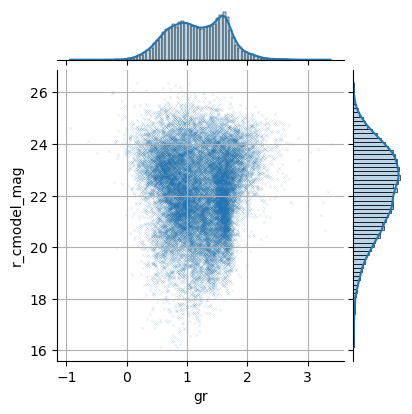

In [2]:
df = pd.read_csv('../../clean-HSC-unWISE-W01.csv')
features = ['gr', 'r_cmodel_mag']
data = df[features]


sns.jointplot(x = df[features[0]], y = df[features[1]], s=5, alpha = 0.3, marker = 'x', marginal_kws=dict(kde = True, fill = True, alpha = 0.3))
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.grid()
plt.gcf().set_size_inches(4,4)

In [9]:
# split into training and validation samples
from sklearn.model_selection import train_test_split
train, val = train_test_split(data, test_size= 0.25, random_state= 42)

mins = np.array(data.min(axis=0))
maxs = np.array(data.max(axis=0))

##### Flows example

100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


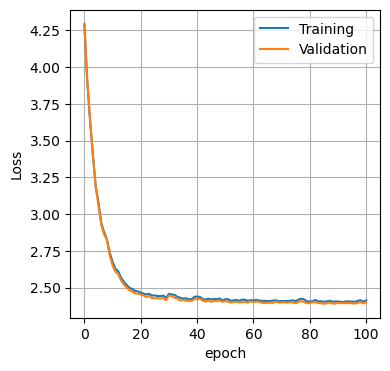

In [5]:
from pzflow import Flow
flow = Flow(features)
losses = flow.train(inputs= train, val_set= val, batch_size= 3000, progress_bar= True)

plt.figure(figsize=(4,4))
plt.plot(losses[0], label = 'Training')
plt.plot(losses[1], label = 'Validation')
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.legend()
plt.grid()

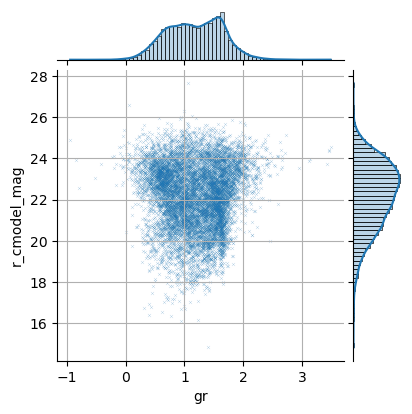

In [6]:
# plot after training
samples = flow.sample(10_000, seed = 0) #it does not work without a seed....
sns.jointplot(x = samples[features[0]], y = samples[features[1]], s=5, alpha =0.5, marker = 'x', marginal_kws=dict(kde = True, fill = True, alpha = 0.3))
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.grid()
plt.gcf().set_size_inches(4,4)

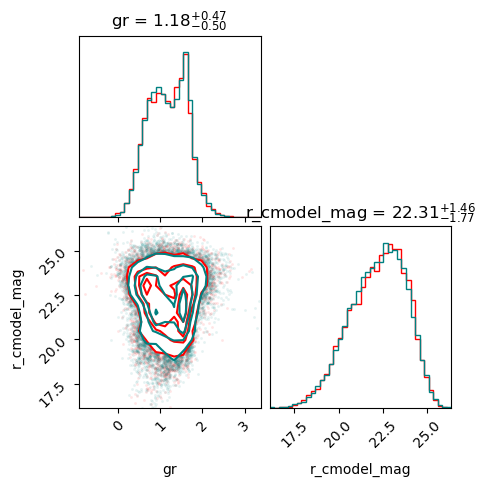

In [11]:
ranges = [(a,b) for a,b in zip(mins,maxs)]
fig = plt.figure(figsize=(5,5))
corner.corner(samples.values, fig=fig, color='red', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2)
corner.corner(data.values, fig=fig, color='teal', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2, show_titles=True, labels=data.columns);

In [15]:
flow.save("pzflow/test.pkl")
# flow = Flow(file="pzflow.pkl") for loading

##### Flows ensemble 

In [12]:
from pzflow import FlowEnsemble
flowEns = FlowEnsemble(features, N=6)
losses = flowEns.train(inputs= train, val_set= val, batch_size= 3000, progress_bar= True)

100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


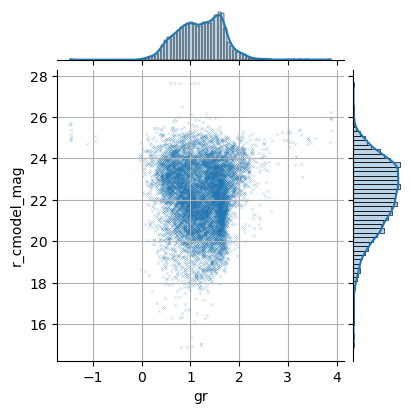

In [16]:
# plot after training
samples = flowEns.sample(10000, seed = 0)
sns.jointplot(x = samples[features[0]], y = samples[features[1]], s=5, alpha = 0.5, marker = 'x', marginal_kws=dict(kde = True, fill = True, alpha = 0.3))
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.grid()
plt.gcf().set_size_inches(4,4)

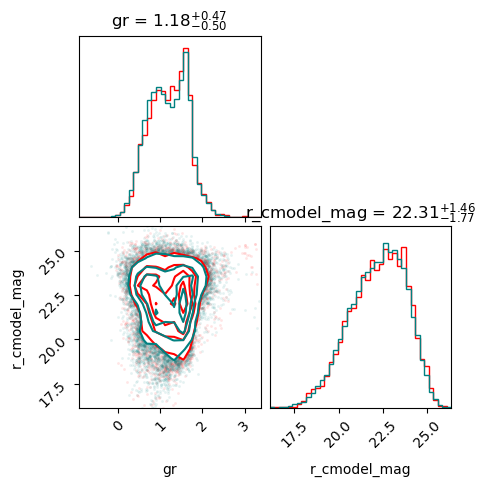

In [14]:
ranges = [(a,b) for a,b in zip(mins,maxs)]
fig = plt.figure(figsize=(5,5))
corner.corner(samples.values, fig=fig, color='red', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2)
corner.corner(data.values, fig=fig, color='teal', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2, show_titles=True, labels=data.columns);

In [17]:
flowEns.save("pzflow/ensemble.pkl")

##### Normal base distribution 1

In [18]:
import pzflow.bijectors as fb

# get minima and maxima for each column
mins = np.array(data.min(axis=0))
maxs = np.array(data.max(axis=0))

# get the number of dimensions
ndim = len(features)
n_layers = 4

# build the bijector
bijector = fb.Chain(
    fb.ShiftBounds(mins, maxs, B=4),    # map data bewtwen mins and max to a range -B,+B
    fb.RollingSplineCoupling(n_layers, B=5),
)

In [19]:
import pzflow.distributions as fd
# base distribution
latent = fd.Normal(input_dim= ndim)   #Uniform(input_dim=ndim, B=5)

100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


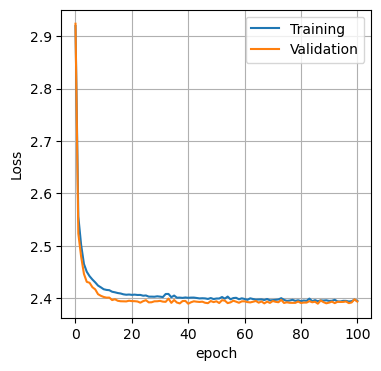

In [21]:
flow = Flow(features,  bijector=bijector, latent=latent)
losses = flow.train(inputs= train, val_set= val, batch_size= 3000, progress_bar= True)

plt.figure(figsize=(4,4))
plt.plot(losses[0], label = 'Training')
plt.plot(losses[1], label = 'Validation')
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.legend()
plt.grid()


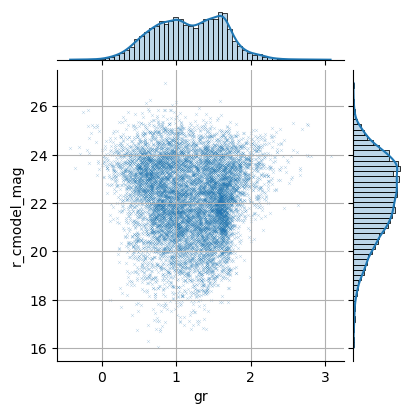

In [22]:
# plot after training
samples = flow.sample(10_000, seed = 0) #it does not work without a seed....
sns.jointplot(x = samples[features[0]], y = samples[features[1]], s=5, alpha =0.5, marker = 'x', marginal_kws=dict(kde = True, fill = True, alpha = 0.3))
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.grid()
plt.gcf().set_size_inches(4,4)

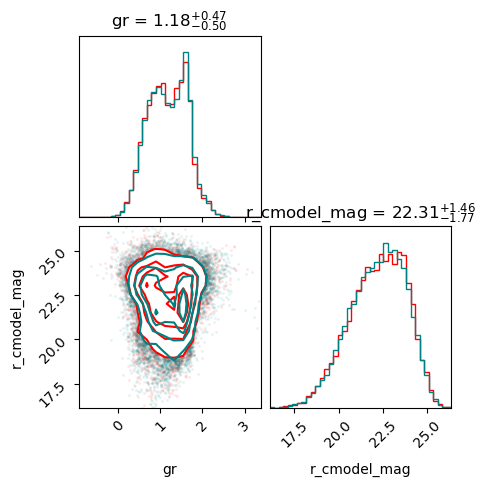

In [23]:
ranges = [(a,b) for a,b in zip(mins,maxs)]
fig = plt.figure(figsize=(5,5))
corner.corner(samples.values, fig=fig, color='red', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2)
corner.corner(data.values, fig=fig, color='teal', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2, show_titles=True, labels=data.columns);

In [24]:
flow.save("pzflow/normal1.pkl")

##### Normal base distribution 2

In [25]:
import pzflow.bijectors as fb

# get minima and maxima for each column
mins = np.array(data.min(axis=0))
maxs = np.array(data.max(axis=0))

# get the number of dimensions
ndim = len(features)
n_layers = 4

# build the bijector
bijector = fb.Chain(
    fb.ShiftBounds(mins, maxs, B=1),    # map data bewtwen mins and max to a range -B,+B
    fb.RollingSplineCoupling(n_layers, B=5),
)

In [26]:
import pzflow.distributions as fd
# base distribution
latent = fd.Normal(input_dim= ndim)   #Uniform(input_dim=ndim, B=5)

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


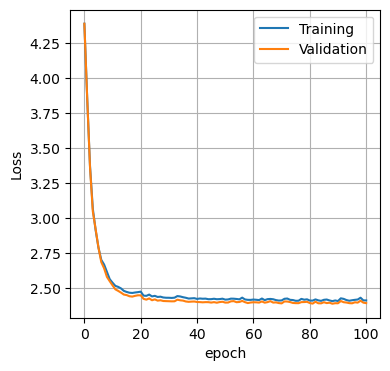

In [28]:
flow = Flow(features,  bijector=bijector, latent=latent)
losses = flow.train(inputs= train, val_set= val, batch_size= 3000, progress_bar= True)

plt.figure(figsize=(4,4))
plt.plot(losses[0], label = 'Training')
plt.plot(losses[1], label = 'Validation')
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.legend()
plt.grid()

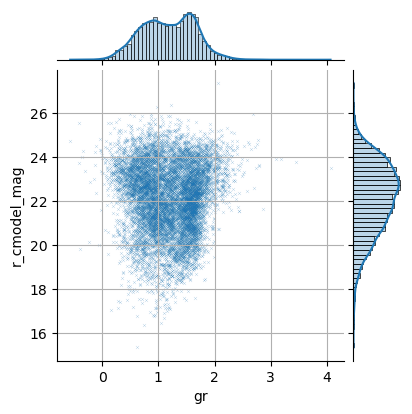

In [29]:
# plot after training
samples = flow.sample(10_000, seed = 0) #it does not work without a seed....
sns.jointplot(x = samples[features[0]], y = samples[features[1]], s=5, alpha =0.5, marker = 'x', marginal_kws=dict(kde = True, fill = True, alpha = 0.3))
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.grid()
plt.gcf().set_size_inches(4,4)

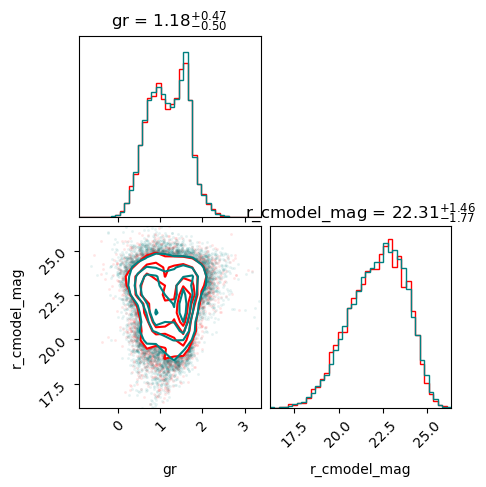

In [30]:
ranges = [(a,b) for a,b in zip(mins,maxs)]
fig = plt.figure(figsize=(5,5))

corner.corner(samples.values, fig=fig, color='red', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2)
corner.corner(data.values, fig=fig, color='teal', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2, show_titles=True, labels=data.columns);

In [31]:
flow.save("pzflow/normal2.pkl")

### 5 variables

##### Data

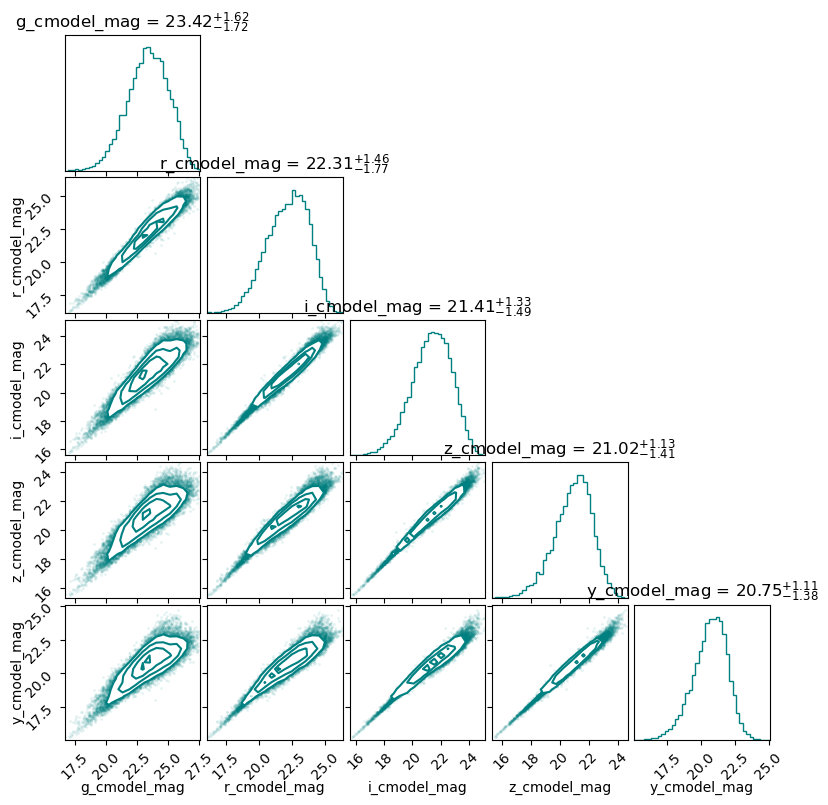

In [6]:
df = pd.read_csv('../../clean-HSC-unWISE-W01.csv')
features = ['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag']
data = df[features]

# split into training and validation samples
from sklearn.model_selection import train_test_split
train, val = train_test_split(data, test_size= 0.25, random_state= 42)

mins = np.array(data.min(axis=0))
maxs = np.array(data.max(axis=0))


ranges = [(a,b) for a,b in zip(mins,maxs)]
fig = plt.figure(figsize=(8,8))
corner.corner(data.values, fig=fig, color='teal', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2, show_titles=True, labels=data.columns);

##### Uniform distributions

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


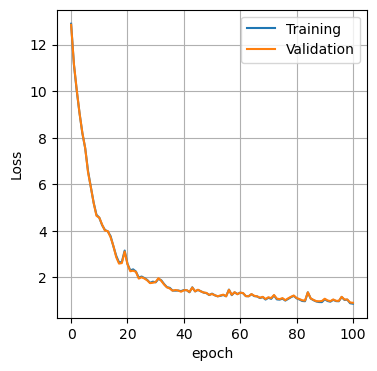

In [7]:
from pzflow import Flow
flow = Flow(features)

losses = flow.train(inputs= train, val_set= val, batch_size= 5000, progress_bar= True)

plt.figure(figsize=(4,4))
plt.plot(losses[0], label = 'Training')
plt.plot(losses[1], label = 'Validation')
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.legend()
plt.grid()

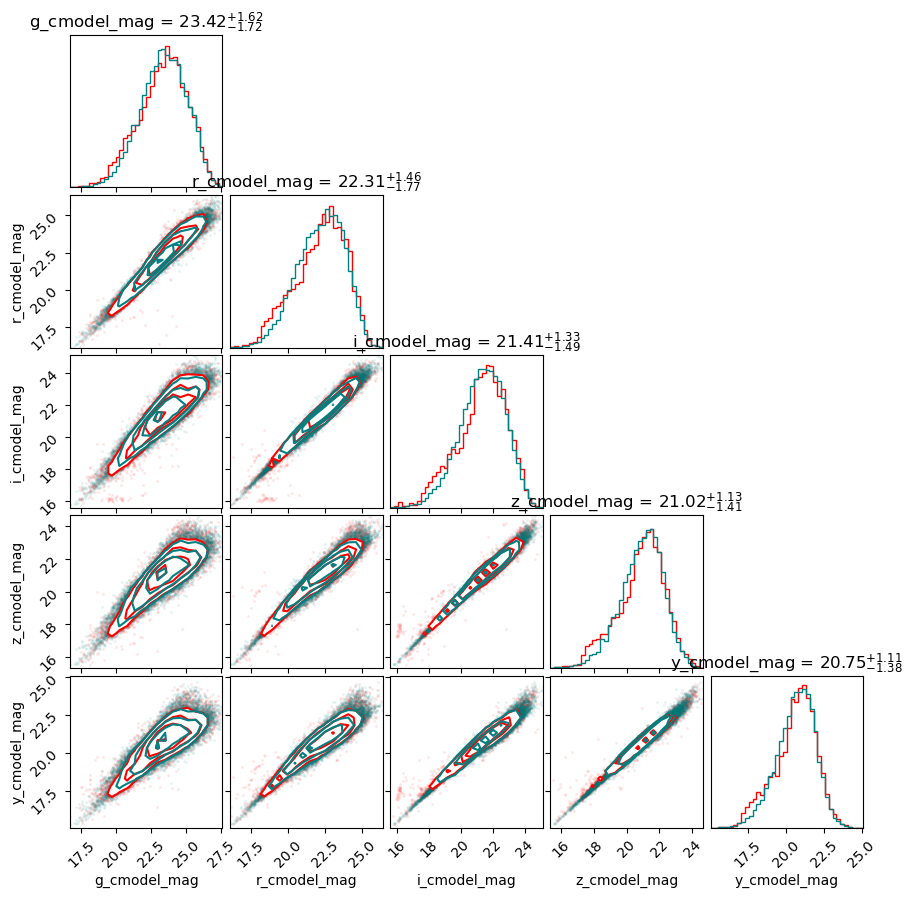

In [8]:
ranges = [(a,b) for a,b in zip(mins,maxs)]
fig = plt.figure(figsize=(9,9))
samples = flow.sample(10_000, seed = 0) #it does not work without a seed....
corner.corner(samples.values, fig=fig, color='red', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2)
corner.corner(data.values, fig=fig, color='teal', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2, show_titles=True, labels=data.columns);

In [10]:
flow.save("pzflow/5var_unif_1.pkl")

##### Normal distribution

In [9]:
ndim = len(features)
import pzflow.distributions as fd
latent = fd.Normal(input_dim= ndim)   

100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


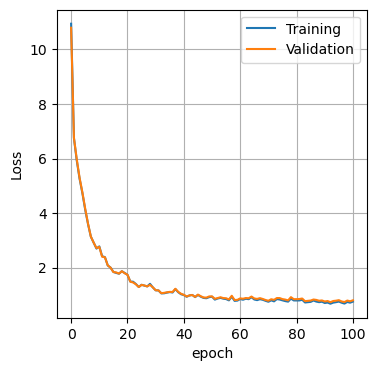

In [11]:
from pzflow import Flow
flow = Flow(features, latent= latent)

losses = flow.train(inputs= train, val_set= val, batch_size= 5000, progress_bar= True)

plt.figure(figsize=(4,4))
plt.plot(losses[0], label = 'Training')
plt.plot(losses[1], label = 'Validation')
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.legend()
plt.grid()

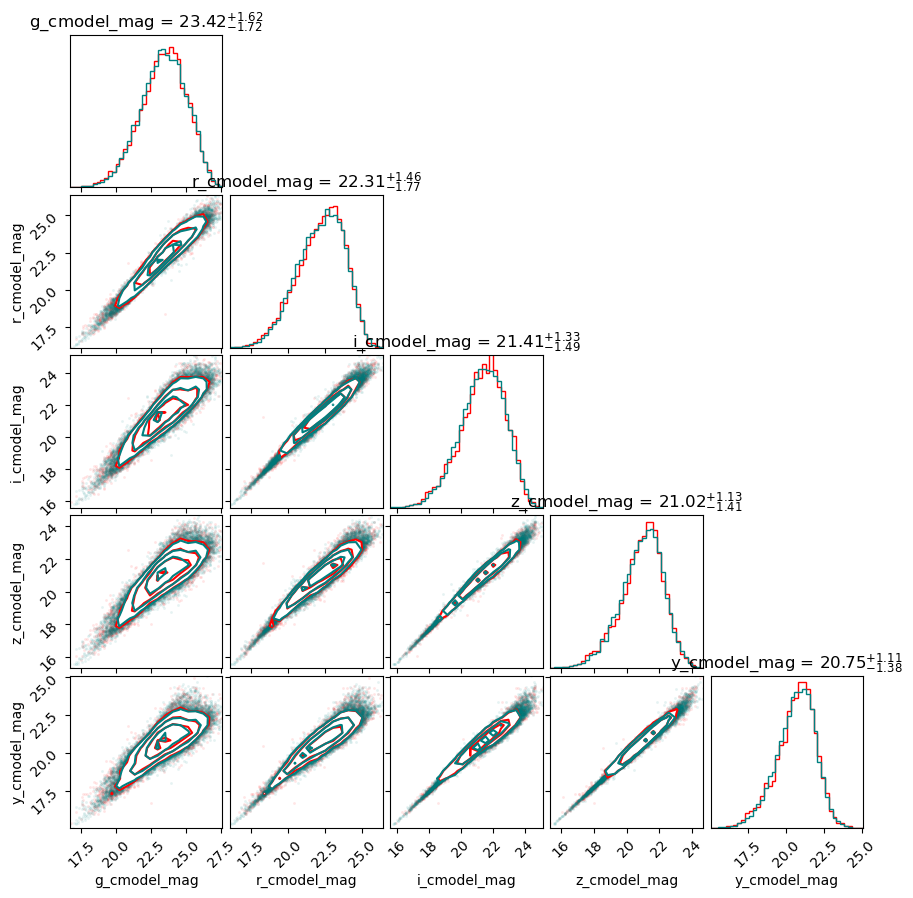

In [12]:
ranges = [(a,b) for a,b in zip(mins,maxs)]
fig = plt.figure(figsize=(9,9))
samples = flow.sample(10_000, seed = 0) #it does not work without a seed....
corner.corner(samples.values, fig=fig, color='red', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2)
corner.corner(data.values, fig=fig, color='teal', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2, show_titles=True, labels=data.columns);

In [13]:
flow.save("pzflow/5var_norm_1.pkl")

### 5 variables + errors

##### Data

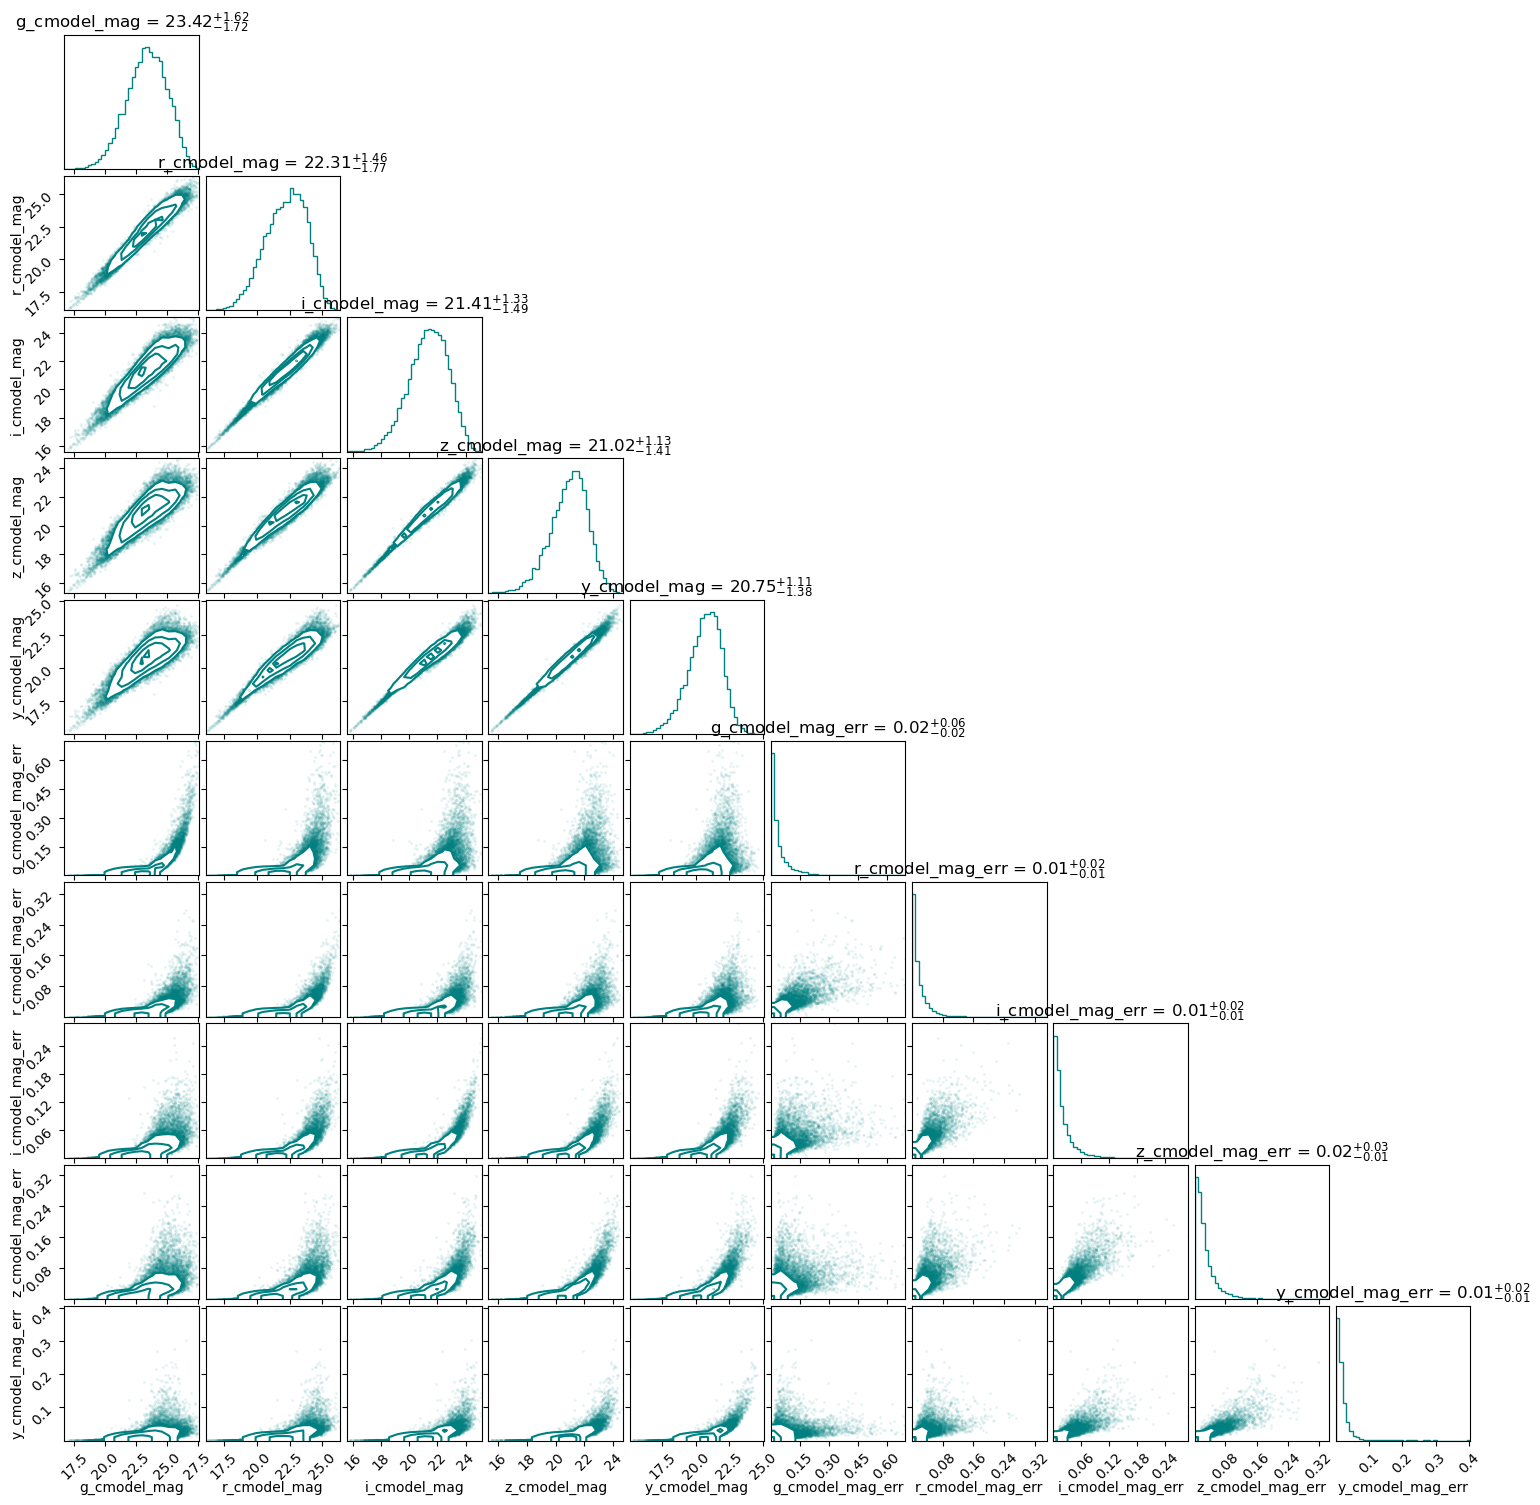

In [33]:
df = pd.read_csv('../../clean-HSC-unWISE-W01.csv')
features = ['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag',
            'g_cmodel_magsigma','r_cmodel_magsigma','i_cmodel_magsigma','z_cmodel_magsigma','y_cmodel_magsigma']
data = df[features]

# split into training and validation samples
from sklearn.model_selection import train_test_split
train, val = train_test_split(data, test_size= 0.25, random_state= 42)

mins = np.array(data.min(axis=0))
maxs = np.array(data.max(axis=0))

ranges = [(a,b) for a,b in zip(mins,maxs)]
fig = plt.figure(figsize=(15,15))
corner.corner(data.values, fig=fig, color='teal', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2, show_titles=True, labels=data.columns);

##### Uniform distribution

100%|██████████| 100/100 [09:28<00:00,  5.69s/it] 


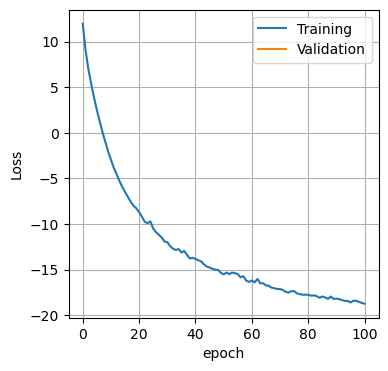

In [16]:
from pzflow import Flow
flow = Flow(features)

opt = optax.adam(learning_rate=1e-4)
losses = flow.train(inputs= train, val_set= val, batch_size= 5000, progress_bar= True, optimizer=opt, epochs= 100)

plt.figure(figsize=(4,4))
plt.plot(losses[0], label = 'Training')
plt.plot(losses[1], label = 'Validation')
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.legend()
plt.grid()

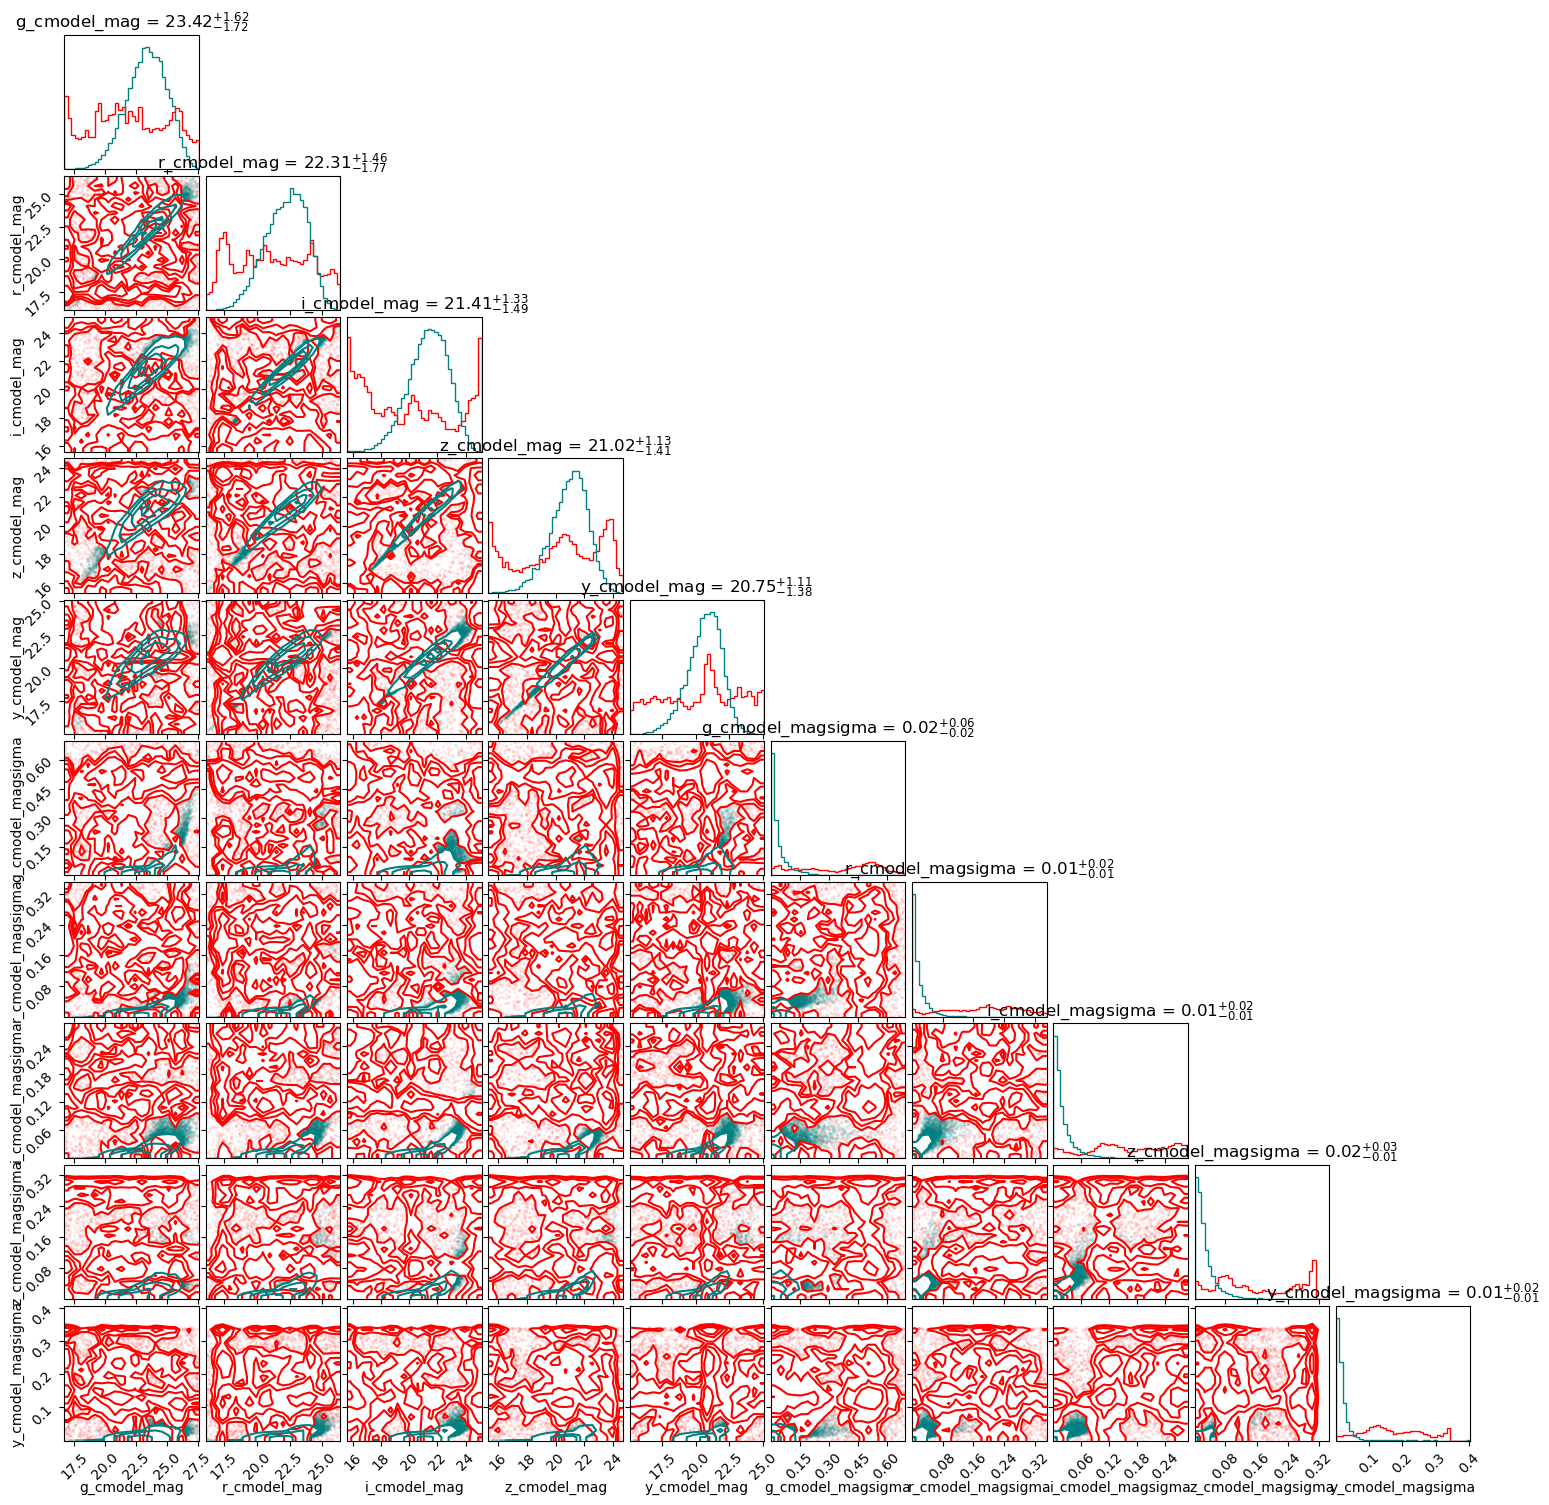

In [18]:
ranges = [(a,b) for a,b in zip(mins,maxs)]
fig = plt.figure(figsize=(15,15))
samples = flow.sample(10_000, seed = 0) #it does not work without a seed....
corner.corner(samples.values, fig=fig, color='red', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2)
corner.corner(data.values, fig=fig, color='teal', bins=20, range=ranges, hist_kwargs={'density': True},  plot_density = False, hist_bin_factor = 2, show_titles=True, labels=data.columns);

<sup><sub><sup>what the fuck</sup></sub></sup>